# Handling netCDF files for simple climate models

In this notebook we give a brief introduction to iris, the library we use for our analysis, before giving a demonstration of some of the key functionality of `netcdf_scm`.

TODO:

- update output of `get_scm_timeseries` to use the `openscm` dataframe.

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join
import datetime
import warnings

import numpy as np
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import iris.analysis.cartography
import matplotlib.pyplot as plt

from netcdf_scm.iris_cube_wrappers import SCMCube, MarbleCMIP5Cube

In [2]:
plt.style.use('bmh') 
%matplotlib inline

In [3]:
DATA_PATH_TEST = join("..", "tests", "test_data")
DATA_PATH_TEST_MARBLE_CMIP5_ROOT = join(DATA_PATH_TEST, "marble_cmip5")

## Loading a cube

### Loading with iris

Here we show how to load a cube directly using iris.

In [4]:
tas_file = join(
    DATA_PATH_TEST_MARBLE_CMIP5_ROOT,
    "cmip5",
    "1pctCO2",
    "Amon",
    "tas",
    "CanESM2",
    "r1i1p1",
    "tas_Amon_CanESM2_1pctCO2_r1i1p1_185001-198912.nc",
)

In [5]:
tas_iris_load = SCMCube()
# you need this in case your cube has multiple variables
variable_constraint = iris.Constraint(
    cube_func=(lambda c: c.var_name == np.str("tas"))
)
# With iris v2.1.0, a bunch of 'Gracefully Filling' 
# warnings are thrown. This is a bug which will disappear 
# in iris v2.2.0 (see https://github.com/SciTools/iris/pull/3171)
# We filter them manually here
warnings.filterwarnings("ignore", ".*Gracefully filling.*")

tas_iris_load.cube = iris.load_cube(tas_file, variable_constraint)

/Users/zebedeenicholls/miniconda3/envs/netcdf-scm/lib/python3.6/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(message % (variable_name, nc_var_name))


The warning tells us that we need to add the areacella as a measure variable to our cube. Doing this manually everytime involves finding the areacella file, loading it, turning it into a cell measure and then adding it to the cube. This is a pain and involves about 100 lines of code. To make life easier, we wrap all of that away using `netcdf_scm`, which we will introduce in the next section.

### Loading with `netcdf_scm`

There are a couple of particularly annoying things involved with processing netCDF data. Firstly, the data is often stored in a folder hierarchy which can be fiddly to navigate. Secondly, the metadata is often stored separate from the variable cubes. 

Hence in `netcdf_scm`, we try to abstract the code which solves these two things away to make life a bit easier. This involves defining a cube in `netcdf_scm.iris_cube_wrappers`. The details can be read there, for now we just give an example.

Our example uses `MarbleCMIP5Cube`. This cube is designed to work with the CMIP5 data on our server at University of Melbourne, which has been organised into a number of folders which are similar, but not quite identical, to the CMOR directory structure described in section 3.1 of the [CMIP5 Data Reference Syntax](https://cmip.llnl.gov/cmip5/docs/cmip5_data_reference_syntax_v1-00_clean.pdf). To facilitate our example, the test data in `DATA_PATH_TEST_MARBLE_CMIP5_ROOT` is organised in the same way.

In any case, with this cube we can simply pass in the information about the data we want (experiment, model, ensemble member etc.) and it will load our desired cube. 

In [6]:
tas = MarbleCMIP5Cube()
tas.load_data(
    root_dir=DATA_PATH_TEST_MARBLE_CMIP5_ROOT,
    activity="cmip5",
    experiment="1pctCO2",
    modeling_realm="Amon",
    variable_name="tas",
    model="CanESM2",
    ensemble_member="r1i1p1",
    time_period="185001-198912",
    file_ext=".nc",
)

We can verify that the loaded cube is exactly the same as the cube we loaded in the previous section (where we provided the full path).

In [7]:
# NBVAL_IGNORE_OUTPUT
assert tas.cube == tas_iris_load.cube

We can have a look at our cube too (note that the broken cell measures representation is intended to be fixed in https://github.com/SciTools/iris/pull/3173).

In [8]:
tas.cube

<iris 'Cube' of air_temperature / (K) (time: 1680; latitude: 64; longitude: 128)>

## Acting on the cube

Once we have loaded our `SCMCube`, we can act on its `cube` attribute like any other Iris Cube. For example, we can add a year categorisation, take an annual mean and then plot the timeseries.

In [9]:
iris.coord_categorisation.add_year(tas.cube, 'time')

/Users/zebedeenicholls/miniconda3/envs/netcdf-scm/lib/python3.6/site-packages/iris/analysis/cartography.py:377: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


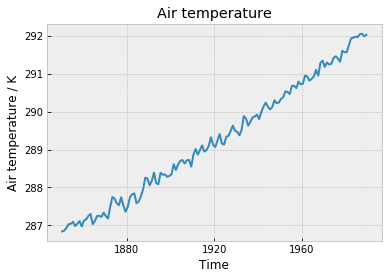

In [10]:
annual_mean = tas.cube.aggregated_by(
    ['year'], # Do the averaging 
    iris.analysis.MEAN
)
global_annual_mean = annual_mean.collapsed(
    ['latitude', 'longitude'], 
    iris.analysis.MEAN,
    weights=iris.analysis.cartography.area_weights(annual_mean)
)
qplt.plot(global_annual_mean);

We can also take a time average and make a spatial plot.

/Users/zebedeenicholls/miniconda3/envs/netcdf-scm/lib/python3.6/site-packages/iris/coords.py:1210: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


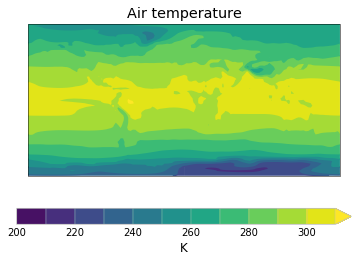

In [11]:
time_mean = tas.cube.collapsed('time', iris.analysis.MEAN)
qplt.contourf(
    time_mean, 
    levels=np.arange(200, 320, 10), 
    extend='max',
);

Add a spatial plot with coastlines.

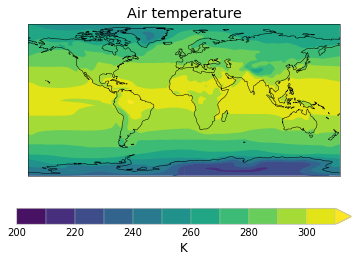

In [12]:
# NBVAL_IGNORE_OUTPUT
# we ignore output here as CI sometimes has to 
# download the map file
qplt.contourf(
    time_mean, 
    levels=np.arange(200, 320, 10), 
    extend='max',
)
plt.gca().coastlines();

## SCM specifics

Finally, we present the key functions of this package which are directly related to processing netCDF files for simple climate models.

### Getting SCM timeseries

The major one is `get_scm_timeseries`. This function wraps a number of steps:

1. load the land surface fraction data
1. combine the land surface fraction and latitude data to determine the hemisphere and land/ocean boxes
1. cut the data into the relevant boxes
1. take a time average in each box
1. return it all as a Pandas Dataframe

As you can imagine, we find it very useful to be able to abstract all these normally nasty steps away.

In [13]:
tas_scm_timeseries = tas.get_scm_timeseries()
tas_scm_timeseries.tail()

VARIABLE            air_temperature                                      \
UNITS                        kelvin                                       
REGION                       GLOBAL     NH_LAND     SH_LAND    NH_OCEAN   
Time                                                                      
1989-08-16 12:00:00      293.992615  302.153198  278.033417  300.008270   
1989-09-16 00:00:00      293.021942  297.349884  280.312500  299.691376   
1989-10-16 12:00:00      291.876343  291.436646  282.827057  298.367065   
1989-11-16 00:00:00      291.099457  285.732147  286.548096  296.926178   
1989-12-16 12:00:00      290.578735  281.864685  288.402039  295.599396   

VARIABLE                         
UNITS                            
REGION                 SH_OCEAN  
Time                             
1989-08-16 12:00:00  288.438385  
1989-09-16 00:00:00  288.251892  
1989-10-16 12:00:00  288.987488  
1989-11-16 00:00:00  290.374481  
1989-12-16 12:00:00  291.779022

Having the data as a Dataframe makes it trivial to plot and work with.

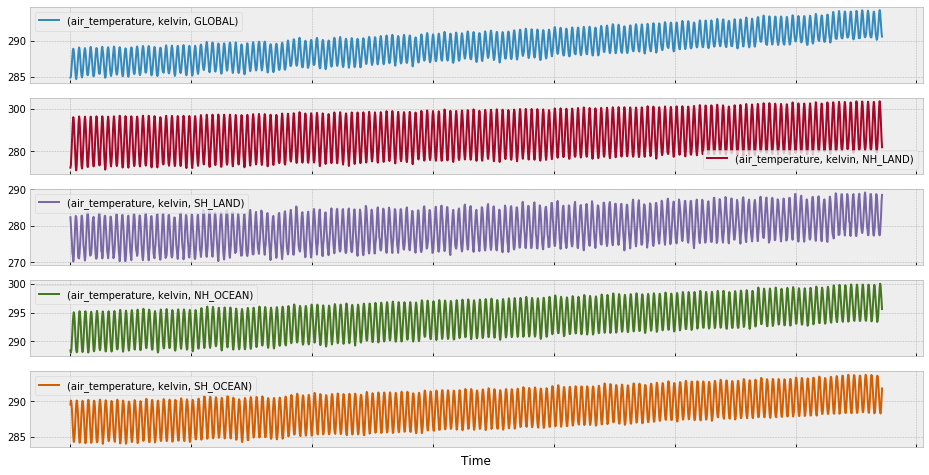

In [14]:
import cftime
tas_scm_timeseries.loc[
    cftime.DatetimeNoLeap(1850, 1, 1):cftime.DatetimeNoLeap(2000, 1, 1)
].plot(subplots=True, figsize=(16, 9));

In [15]:
tas_scm_timeseries.df["YEAR"] = [dt.year for dt in tas_scm_timeseries.index.values]
tas_scm_timeseries_annual_mean = tas_scm_timeseries.groupby("YEAR").mean()
tas_scm_timeseries_annual_mean.head()

VARIABLE air_temperature                                                
UNITS             kelvin                                                
REGION            GLOBAL     NH_LAND     SH_LAND    NH_OCEAN    SH_OCEAN
YEAR                                                                    
1850          286.844482  283.771820  276.353119  291.537872  287.223877
1851          286.862946  283.782806  276.446930  291.628662  287.168915
1852          286.937866  284.053589  276.541290  291.665649  287.162598
1853          287.036346  284.194336  277.046265  291.678955  287.209381
1854          287.044708  284.457397  276.451141  291.792389  287.137573

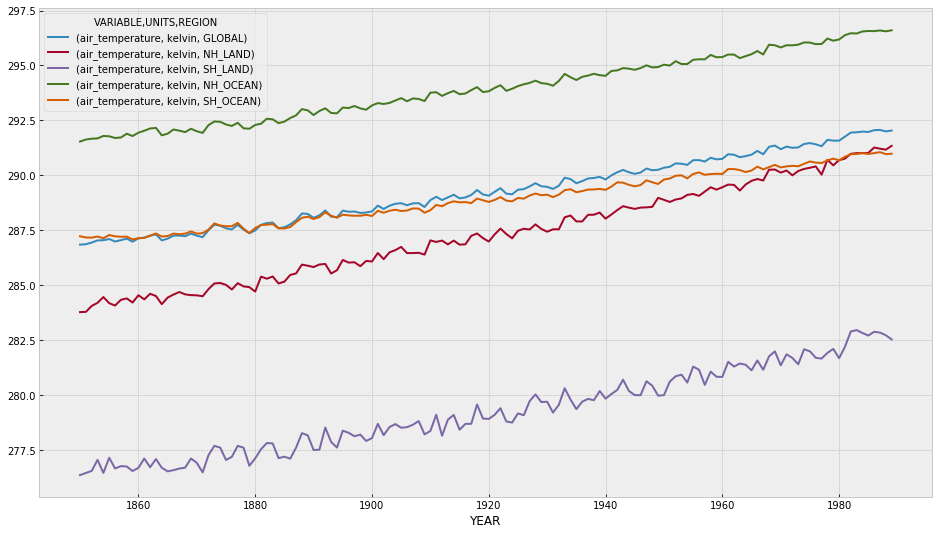

In [16]:
tas_scm_timeseries_annual_mean.plot(figsize=(16, 9));

### Getting SCM cubes

Our other utility function is `get_scm_cubes`. This function is very similar to `get_scm_timeseries` but returns cubes rather than a Dataframe. However, each of the cube's data is masked for the region of interest. Hence it is useful for spatial plots and other, more complicated than pure timeseries, analysis.

In [17]:
tas_scm_cubes = tas.get_scm_cubes()

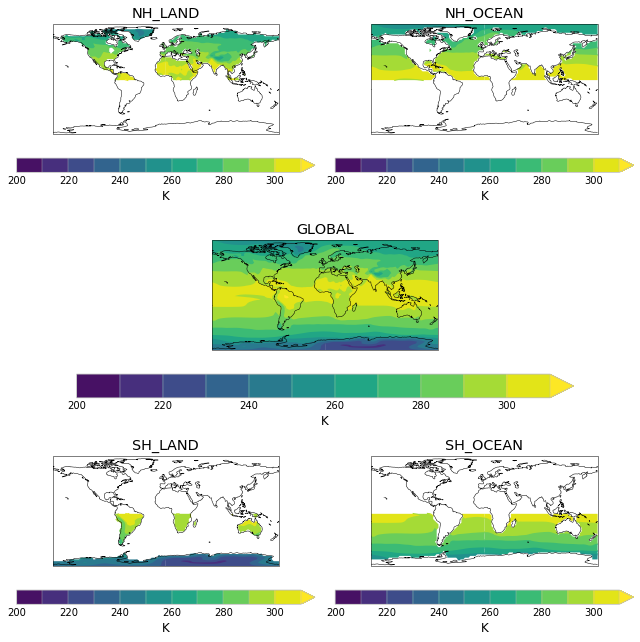

In [39]:
plt.figure(figsize=(9, 9))
for i, (label, cube) in enumerate(tas_scm_cubes.items()):
    if label == "GLOBAL":
        plt.subplot(312)
    else:
        if label == "NH_LAND":
            j = 1
        elif label == "NH_OCEAN":
            j = 2
        elif label == "SH_LAND":
            j = 5
        elif label == "SH_OCEAN":
            j = 6
        plt_no = 320 + j
        plt.subplot(plt_no)
        
    region_time_mean = cube.cube.collapsed('time', iris.analysis.MEAN)
    qplt.contourf(
        region_time_mean, 
        levels=np.arange(200, 320, 10), 
        extend='max',
    )
    plt.gca().coastlines()
    plt.title(label)

plt.tight_layout()